Celeb Faces Dataset (CelebA)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Arias, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020  

We'll do the same thing again but with a more interesting dataset:  CelebFaces  
About this dataset : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## Episode 1 : Preparation of data

 - Understanding the dataset
 - Preparing and formatting enhanced data
 - Save enhanced datasets in h5 file format


## Step 1 - Import and init
### 1.2 - Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io

import os,time,sys,json,glob
import csv
import math, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.2.7
Run time             : Sunday 9 February 2020, 14:22:14
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf


### 1.2 - Directories and files :

In [2]:
# ---- The dataset directory
dataset_dir = '/bettik/PROJECTS/pr-fidle/datasets/celeba'

## Step 2 - Understanding the dataset

### 2.1 - Read the catalog file

In [3]:
dataset_csv = f'{dataset_dir}/list_attr_celeba.csv'
dataset_img = f'{dataset_dir}/img_align_celeba'

# ---- Read dataset attributes

dataset_desc = pd.read_csv(dataset_csv, header=0)

# ---- Have a look

display(dataset_desc.head(5))

print(f'\nDonnées manquantes : {dataset_desc.isna().sum().sum()}')
print(f'dataset_desc.shape : {dataset_desc.shape}')

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1



Données manquantes : 0
dataset_desc.shape : (202599, 41)


### 2.2 - Load 1000 images

In [4]:
start_time = time.time()

nb_images=1000
filenames = [ f'{dataset_img}/{i}' for i in dataset_desc.image_id[:nb_images] ]
x=[]
for filename in filenames:
    image=io.imread(filename)
    x.append(image)
    ooo.update_progress("1000 images :",len(x),nb_images)
x_data=np.array(x)
x=None
    
duration=time.time()-start_time
reload(ooo)
print(f'\nDuration   : {duration:.2f} s')
print(f'Shape is   : {x_data.shape}')
print(f'Numpy type : {x_data.dtype}')

ooo.display_md('<br>**Note :** Estimation for **200.000** normalized images : ')
x_data=x_data/255
print(f'Charging time : {200*duration:.2f} s or {ooo.hdelay(200*duration)}')
print(f'Numpy type    : {x_data.dtype}')
print(f'Memory size   : {ooo.hsize(200*x_data.nbytes)}')

1000 images :    [########################################] 100.0% of 1000

Duration   : 18.34 s
Shape is   : (1000, 218, 178, 3)
Numpy type : uint8


<br>**Note :** Estimation for **200.000** normalized images : 

Charging time : 3667.22 s or 1:01:07
Numpy type    : float64
Memory size   : 173.5 Go


## Step 3 - Have a look

### 3.1 - Few statistics
We want to know if our images are homogeneous in terms of size, ratio, width or height.

In [5]:
data_size  = []
data_ratio = []
data_lx    = []
data_ly    = []

for image in x_data:
    (lx,ly,lz) = image.shape
    data_size.append(lx*ly/1024)
    data_ratio.append(lx/ly)
    data_lx.append(lx)
    data_ly.append(ly)

df=pd.DataFrame({'Size':data_size, 'Ratio':data_ratio, 'Lx':data_lx, 'Ly':data_ly})
display(df.describe().style.format("{0:.2f}").set_caption("About our images :"))
    

,Size,Ratio,Lx,Ly
count,1000.00,1000.00,1000.00,1000.00
mean,37.89,1.22,218.00,178.00
std,0.00,0.00,0.00,0.00
min,37.89,1.22,218.00,178.00
25%,37.89,1.22,218.00,178.00
50%,37.89,1.22,218.00,178.00
75%,37.89,1.22,218.00,178.00
max,37.89,1.22,218.00,178.00


### 3.2 - What does it really look like

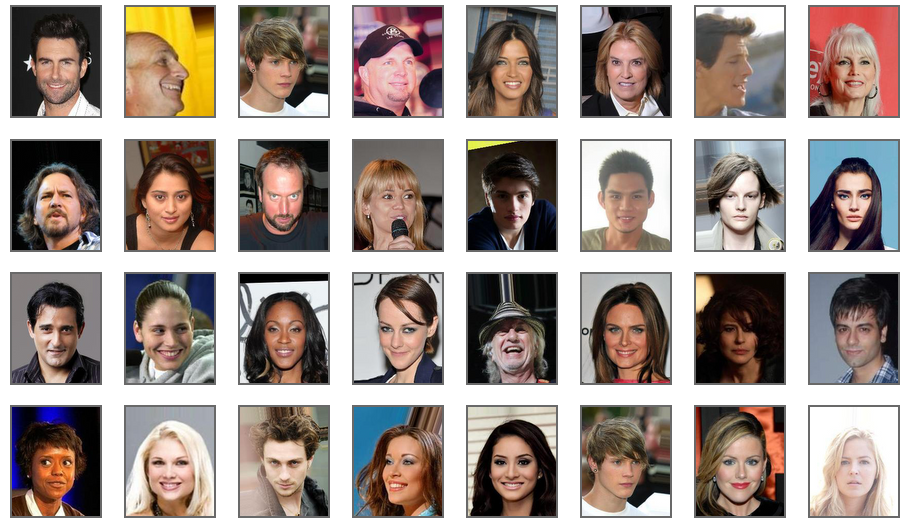

In [6]:
samples = [ random.randint(0,len(x_data)-1) for i in range(32)]
ooo.plot_images(x_data, indices=samples, columns=8, x_size=2, y_size=2)

<div class=warn>
Fine ! :-)<br>But how can we effectively use this dataset, considering its size and the number of files ?<br>
We're talking about a 10' of loading time and 170 GB of data... ;-(
<div/>

## Step 4 - Save as clusters of n images
### 4.1 - A nice function :
Who will read the .jpg images and build the clusters, with :
 - **dataset_img** : The folder where the .jgp images are located.
 - **dataset_desc** : A Pandas DataFrame with the list of images and associated attributes
 - **cluster_size** : Cluster size (ie number of images per cluster)
 - **cluster_dir** : Where to put the cluster files

In [8]:
def read_and_save( dataset_img, dataset_desc, cluster_size=1000, cluster_dir='./dataset_cluster'):
    
    def save_cluster(imgs,desc,cols,id):
        file_img  = f'{cluster_dir}/images-{id:03d}.npy'
        file_desc = f'{cluster_dir}/images-{id:03d}.csv'
        np.save(file_img,  np.array(imgs))
        df=pd.DataFrame(data=desc,columns=cols)
        df.to_csv(file_desc, index=False)
        return [],[],id+1
    
    start_time = time.time()
    cols = list(dataset_desc.columns)

    # ---- Check
    if os.path.isfile(f'{cluster_dir}/images-000.npy'):
        print('\n*** Oops. There are already clusters in the target folder!\n')
        return 0,0
    
    # ---- Create cluster_dir
    os.makedirs(cluster_dir, mode=0o750, exist_ok=True)
    
    # ---- Read and save clusters
    imgs, desc, cluster_id = [],[],0
    for i,row in dataset_desc.iterrows():
        filename = f'{dataset_img}/{row.image_id}'
        # ---- Add image and description
        imgs.append( io.imread(filename) )
        desc.append( row.values )
        # ---- Progress bar
        ooo.update_progress(f'Cluster {cluster_id:03d} :',len(imgs),cluster_size)
        # ---- Save cluster if full
        if len(imgs)==cluster_size:
            imgs,desc,cluster_id=save_cluster(imgs,desc,cols, cluster_id)

    # ---- Save uncomplete cluster
    if len(imgs)>0 : imgs,desc,cluster_id=save_cluster(imgs,desc,cols,cluster_id)

    duration=time.time()-start_time
    return cluster_id,duration


### 4.2 - A friendly construction of our clusters
Reading the 200,000 images can take up to 20 minutes.  
The 21 clusters will represent about 21 GB.  
If the target folder is not empty, the construction is blocked.

In [11]:
# ---- Cluster size

cluster_size = 100

# ---- Clusters location

cluster_dir  = f'{dataset_dir}/clusters-test'

# ---- Read images and save in clusters

n,d = read_and_save(dataset_img, dataset_desc[:932], cluster_size, cluster_dir)
        
print(f'\n\nDuration : {d:.2f} s or {ooo.hdelay(d)}')
print(f'Have a look in : {cluster_dir}')

Cluster 000 :    [########################################] 100.0% of 100
Cluster 001 :    [########################################] 100.0% of 100
Cluster 002 :    [########################################] 100.0% of 100
Cluster 003 :    [########################################] 100.0% of 100
Cluster 004 :    [########################################] 100.0% of 100
Cluster 005 :    [########################################] 100.0% of 100
Cluster 006 :    [########################################] 100.0% of 100
Cluster 007 :    [########################################] 100.0% of 100
Cluster 008 :    [########################################] 100.0% of 100
Cluster 009 :    [#############---------------------------]  32.0% of 100
Duration : 3.53 s or 0:00:03
Have a look in : /bettik/PROJECTS/pr-fidle/datasets/celeba/clusters-test


----
That's all folks !